In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17937030084066812367
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2357670708
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14175812775496957954
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
!nvidia-smi


Tue May 27 04:02:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.19                 Driver Version: 561.19         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   46C    P0             15W /   50W |      49MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
!where cudart64_110.dll

C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.8\bin\cudart64_110.dll


In [ ]:
import zipfile
import os
import glob

zip_path = 'data/raw/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone.zip'

extract_path = 'data/extract'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

data_dir = 'data/extract/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'

# List class names (folder names)
classes = sorted(os.listdir(data_dir))
print("Detected classes:", classes)


Detected classes: ['Cyst', 'Normal', 'Stone', 'Tumor']


In [7]:
classes = sorted(os.listdir(data_dir))
class_to_index = {cls: i for i, cls in enumerate(classes)}

image_paths = []
labels = []

for cls in classes:
    cls_path = os.path.join(data_dir, cls)
    for img_file in glob.glob(os.path.join(cls_path, "*")):
        image_paths.append(img_file)
        labels.append(class_to_index[cls])


In [8]:
from sklearn.model_selection import train_test_split

train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.3, stratify=labels, random_state=42
)


In [9]:
import cv2
import numpy as np

def preprocess_img(img_path, target_size=(224, 224)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img.astype('float32') / 255.0
    return img


In [10]:
from tensorflow.keras.utils import to_categorical

def data_generator(image_paths, labels, batch_size, num_classes):
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            batch_images = [preprocess_img(p) for p in batch_paths]
            yield np.array(batch_images), to_categorical(np.array(batch_labels), num_classes)


In [11]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

IMG_SHAPE = (224, 224, 3)
NUM_CLASSES = len(classes)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
base_model.trainable = False  # freeze base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
BATCH_SIZE = 32
EPOCHS = 100

train_gen = data_generator(train_paths, train_labels, BATCH_SIZE, NUM_CLASSES)
val_gen = data_generator(test_paths, test_labels, BATCH_SIZE, NUM_CLASSES)

steps_per_epoch = len(train_paths) // BATCH_SIZE
val_steps = len(test_paths) // BATCH_SIZE

# Clear memory just in case
import gc
gc.collect()
tf.keras.backend.clear_session()

history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=val_steps,
    epochs=EPOCHS
)


Epoch 1/100
272/272 [==============================] - 225s 804ms/step - loss: 1.2682 - accuracy: 0.4352 - val_loss: 1.1714 - val_accuracy: 0.5719
Epoch 2/100
272/272 [==============================] - 93s 338ms/step - loss: 1.1375 - accuracy: 0.5605 - val_loss: 1.0667 - val_accuracy: 0.6369
Epoch 3/100
272/272 [==============================] - 92s 339ms/step - loss: 1.0380 - accuracy: 0.6265 - val_loss: 0.9735 - val_accuracy: 0.6649
Epoch 4/100
272/272 [==============================] - 92s 339ms/step - loss: 0.9537 - accuracy: 0.6662 - val_loss: 0.8957 - val_accuracy: 0.6932
Epoch 5/100
272/272 [==============================] - 92s 339ms/step - loss: 0.8807 - accuracy: 0.6914 - val_loss: 0.8299 - val_accuracy: 0.7198
Epoch 6/100
272/272 [==============================] - 92s 339ms/step - loss: 0.8197 - accuracy: 0.7181 - val_loss: 0.7758 - val_accuracy: 0.7349
Epoch 7/100
272/272 [==============================] - 92s 340ms/step - loss: 0.7720 - accuracy: 0.7335 - val_loss: 0.7297 

In [14]:
# base_model.trainable = True
# for layer in base_model.layers[:-4]:
#     layer.trainable = False

# model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# history_finetune = model.fit(
#     train_gen,
#     steps_per_epoch=steps_per_epoch,
#     validation_data=val_gen,
#     validation_steps=val_steps,
#     epochs=5
# )


In [26]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [15]:
model.save("vgg16_finetuned_model.keras")


1/1 [==============================] - 0s 266ms/step


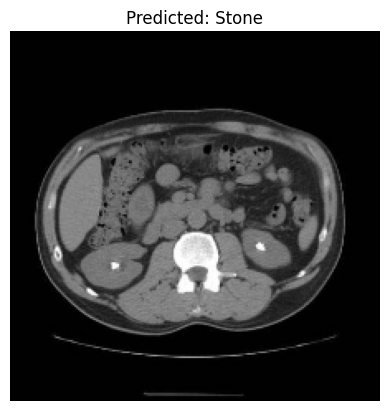

In [24]:
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt

# --- Load Trained Model ---
model = load_model("vgg16_finetuned_model.keras")

# --- Define Preprocessing Function (Same as Training) ---
def preprocess_img(img_path, target_size=(224, 224)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img.astype('float32') / 255.0
    return img

# --- Load and Preprocess Image ---
test_image_path = "kidney_stone1.jpeg"  # Change this
img = preprocess_img(test_image_path)
img_batch = np.expand_dims(img, axis=0)  # Add batch dimension

# --- Predict ---
pred = model.predict(img_batch)
pred_class_idx = np.argmax(pred, axis=1)[0]
pred_class_label = classes[pred_class_idx]  # classes from earlier step

# --- Show Result ---
plt.imshow(img)
plt.title(f"Predicted: {pred_class_label}")
plt.axis("off")
plt.show()


In [17]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()


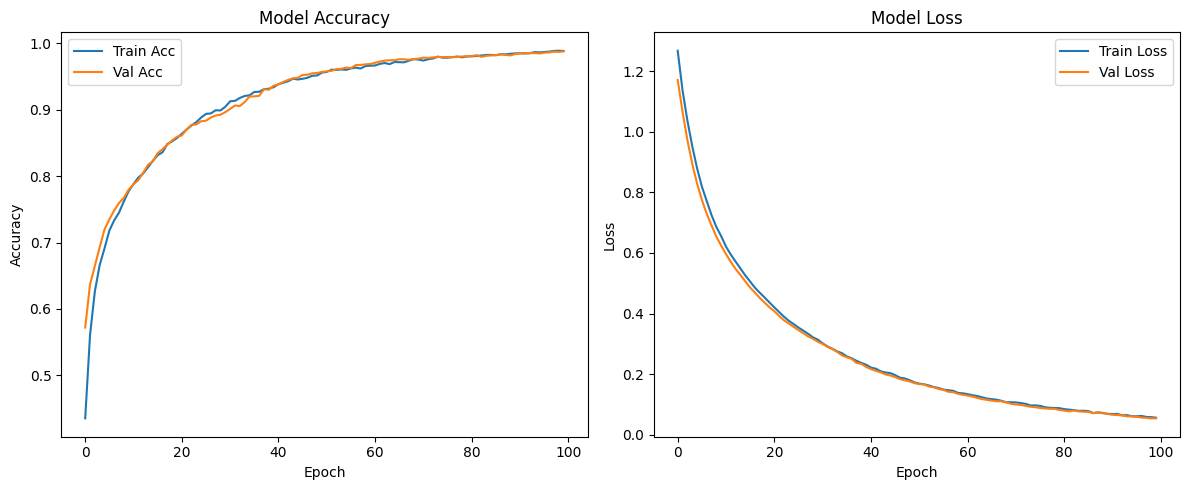

In [18]:
# Call this after training is done
plot_training_history(history)


1/1 [==============================] - 0s 50ms/step

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.98      0.99      0.99      1104
     Class 1       0.99      1.00      0.99      1515
     Class 2       0.99      0.95      0.97       412
     Class 3       0.99      0.99      0.99       681

    accuracy                           0.99      3712
   macro avg       0.99      0.98      0.98      3712
weighted avg       0.99      0.99      0.99      3712



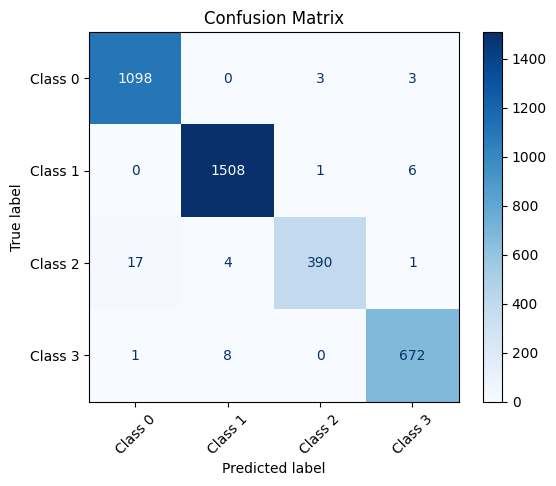

Accuracy: 0.9881465517241379


In [19]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# 1. Generate predictions
y_true = []
y_pred = []

# Iterate over validation data
for i in range(val_steps):
    x_batch, y_batch = next(val_gen)
    
    # Model predictions
    y_pred_batch = model.predict(x_batch)
    
    # Get class indices
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(y_pred_batch, axis=1))

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 2. Classification report
print("\nClassification Report:")
target_names = [f'Class {i}' for i in range(NUM_CLASSES)]  # or your actual class labels
print(classification_report(y_true, y_pred, target_names=target_names))

# 3. Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# 4. Accuracy
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_true, y_pred))


In [20]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np


In [21]:
y_true = []
y_probs = []

for i in range(val_steps):
    x_batch, y_batch = next(val_gen)
    y_prob_batch = model.predict(x_batch)
    
    y_true.extend(y_batch)
    y_probs.extend(y_prob_batch)

# Convert to numpy arrays
y_true = np.array(y_true)
y_probs = np.array(y_probs)


1/1 [==============================] - 0s 40ms/step


C:\Users\gaura\AppData\Local\Temp\ipykernel_18216\143691095.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', NUM_CLASSES)


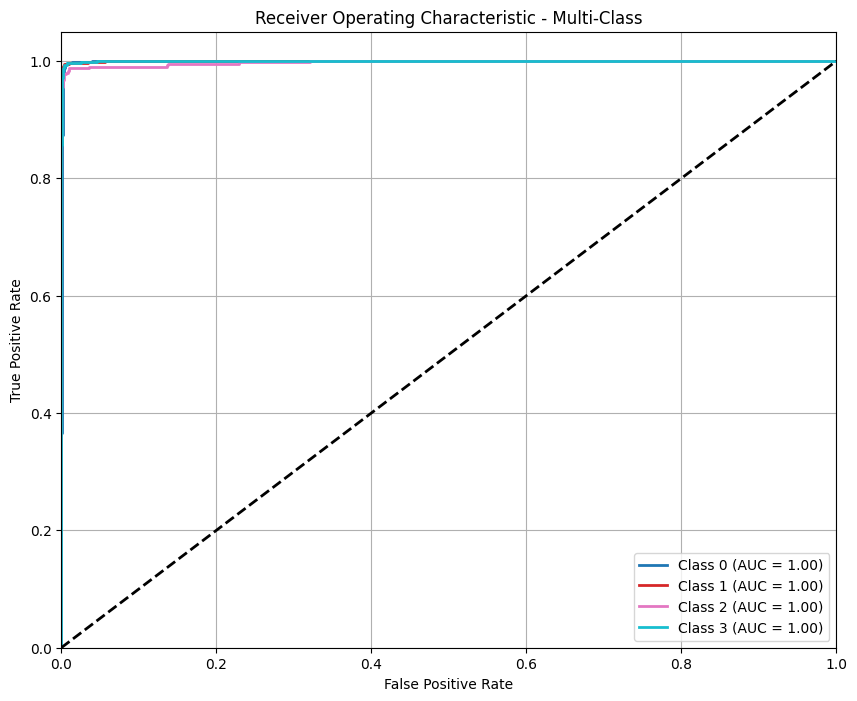

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', NUM_CLASSES)

for i in range(NUM_CLASSES):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})', color=colors(i))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Multi-Class')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
